# **Importing libraries**

In [64]:
# text preprocessing
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

# to clear emojis
import re

# plots and metrics
import matplotlib.pyplot as plt
from keras.utils import pad_sequences
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_validate

# model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

# other
import string
import numpy as np
import pandas as pd

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Reading the data**

In [65]:
# read data
train_negative = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_negative_20190413.tsv', sep='\t' , header=None) 
train_positive = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/train_Arabic_tweets_positive_20190413.tsv' , sep='\t', header=None) 
test_negative = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_negative_20190413.tsv' , sep='\t', header=None) 
test_positive = pd.read_csv('/kaggle/input/arabic-sentiment-twitter-corpus/test_Arabic_tweets_positive_20190413.tsv' , sep='\t', header=None) 

train_negative.rename(columns={0:'label', 1:'tweet'}, inplace=True)
train_positive.rename(columns={0:'label', 1:'tweet'}, inplace=True)
test_negative.rename(columns={0:'label', 1:'tweet'}, inplace=True)
test_positive.rename(columns={0:'label', 1:'tweet'}, inplace=True)

train_data = pd.concat([train_positive, train_negative], axis=0)
test_data = pd.concat([test_positive, test_negative], axis=0)

train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

# shuffle dataset
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

data = train_data.append(test_data, ignore_index=True)
data.rename(columns={0:'label', 1:'tweet'}, inplace=True)

In [66]:
test_data["label"].value_counts()

neg    4455
pos    4386
Name: label, dtype: int64

In [67]:
data

,label,tweet
0,pos,وما كان الله ليعذبهم وأنت فيهم ۚ وما كان الله ...
1,neg,مهو خلاص انا اعتبرت الحلم اتحقق 😭
2,pos,موفقين يارب 🤲 💙 صبآح الخير 🌹
3,pos,صباح الخير من شباك غرفتي 💙
4,pos,لك الحمد ولك الشكر يا الله 💙
...,...,...
38390,pos,الله ع ايام الطير 😌
38391,pos,من سنن الحبيب ﷺ ❤ العفو عن الخدم عند الخطأ؛ وت...
38392,pos,لا يابن الحلال مانبي زواج نبي جواائز 😂
38393,neg,حلو ده 😂


# **Preprocessing and getting the tweets ready for the model**

In [68]:
# clear tweets and get them ready for the model
def remove_emojis(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', tweet)

def remove_diacritics(tweet):
    arabic_diacritics = re.compile("""
                                 ّ    | # Shadda
                                 َ    | # Fatha
                                 ً    | # Tanwin Fath
                                 ُ    | # Damma
                                 ٌ    | # Tanwin Damm
                                 ِ    | # Kasra
                                 ٍ    | # Tanwin Kasr
                                 ْ    | # Sukun
                                 ـ     # Tatwil/Kashida
                             """, re.VERBOSE)
    return arabic_diacritics.sub(r' ', tweet)

punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation

def clean_tweet(tweet):        
    # Remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet)
    
    #remove punctuations
    translator = str.maketrans('', '', punctuations)
    tweet = tweet.translate(translator)
    
    # remove Tashkeel
    tweet = remove_diacritics(tweet)
    
    #remove longation
    tweet = re.sub("[إأآا]", "ا", tweet)
    tweet = re.sub("ى", "ي", tweet)
    tweet = re.sub("ؤ", "ء", tweet)
    tweet = re.sub("ئ", "ء", tweet)
    tweet = re.sub("ة", "ه", tweet)
    tweet = re.sub("گ", "ك", tweet)

    # Remove Stopwords
    stop_words = set(stopwords.words('arabic'))
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    tweet = pattern.sub('', tweet)
    
    # remove hashtags and @usernames
    tweet = re.sub(r"(#[\d\w\.]+)", '', tweet)
    tweet = re.sub(r"(@[\d\w\.]+)", '', tweet)
    
    # tekenization using nltk
    tweet = word_tokenize(tweet)
    
    return tweet

In [69]:
X_train = train_data["tweet"]
X_test = test_data["tweet"]
X = data["tweet"]

y_train = train_data["label"]
y_test = test_data["label"]
y = data["tweet"]

texts = [' '.join(clean_tweet(text)) for text in data["tweet"]]

In [70]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Use that tokenizer to transform the tweets in the training and test sets
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X = tokenizer.texts_to_sequences(X)

# Pad the sequences so each sequence is the same length
X_train = pad_sequences(X_train, 50)
X_test = pad_sequences(X_test, 50)
X = pad_sequences(X, 50)

In [71]:
# encoding the labels column
encoding = {
    'neg': 0,
    'pos': 1
}

y_train = [encoding[x] for x in train_data["label"]]
y_test = [encoding[x] for x in test_data["label"]]
y = [encoding[x] for x in data["label"]]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y = to_categorical(y)

In [72]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X = np.array(X)

y_train = np.array(y_train)
y_test = np.array(y_test)
y = np.array(y)

# **Baseline model**

In [73]:
epochs_num = 5
batch_size = 50

In [74]:
baseline_model = Sequential()

baseline_model.add(Embedding(len(tokenizer.index_word)+1, 64))
baseline_model.add(LSTM(64,  return_sequences=True))
baseline_model.add(LSTM(32))
baseline_model.add(Dense(2, activation='sigmoid'))
baseline_model.summary()
# Compile the model
baseline_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 64)          5008000   
                                                                 
 lstm_18 (LSTM)              (None, None, 64)          33024     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5,053,506
Trainable params: 5,053,506
Non-trainable params: 0
_________________________________________________________________


In [77]:
history_baseline = baseline_model.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=epochs_num)

Epoch 1/5
592/592 [==============================] - 53s 89ms/step - loss: 0.0164 - accuracy: 0.9939
Epoch 2/5
592/592 [==============================] - 52s 88ms/step - loss: 0.0121 - accuracy: 0.9945
Epoch 3/5
592/592 [==============================] - 53s 89ms/step - loss: 0.0107 - accuracy: 0.9945
Epoch 4/5
592/592 [==============================] - 52s 88ms/step - loss: 0.0094 - accuracy: 0.9946
Epoch 5/5
592/592 [==============================] - 54s 91ms/step - loss: 0.0095 - accuracy: 0.9947


In [78]:
y_pred = baseline_model.predict(X_test)
y_test_for_baseline = np.argmax(y_test, axis=1)

baseline_predictions = []
for i in range(len(y_pred)):
    if y_pred[i][0] > y_pred[i][1]:
        baseline_predictions.append(0)
    elif y_pred[i][0] <= y_pred[i][1]:
        baseline_predictions.append(1)
        
baseline_predictions = np.array(baseline_predictions)

baseline_precision = precision_score(y_test_for_baseline, baseline_predictions)
baseline_recall = recall_score(y_test_for_baseline, baseline_predictions)
baseline_accuracy = accuracy_score(y_test_for_baseline, baseline_predictions)
baseline_f1 = f1_score(y_test_for_baseline, baseline_predictions);

print("Precision score = ", round(baseline_precision, 3))
print("Recall score = ", round(baseline_precision, 3))
print("Accuracy score = ", round(baseline_precision, 3))
print("F1 score = ", round(baseline_f1, 3))

277/277 [==============================] - 5s 16ms/step
Precision score =  0.914
Recall score =  0.914
Accuracy score =  0.914
F1 score =  0.911


In [79]:
baseline_confusionMatrix = confusion_matrix(y_test_for_baseline, baseline_predictions)
print("True negative : " , baseline_confusionMatrix[0][0])
print("False negative : " , baseline_confusionMatrix[0][1])
print("True positive : " , baseline_confusionMatrix[1][1])
print("False positive : " , baseline_confusionMatrix[1][0])

True negative :  4080
False negative :  375
True positive :  3986
False positive :  400


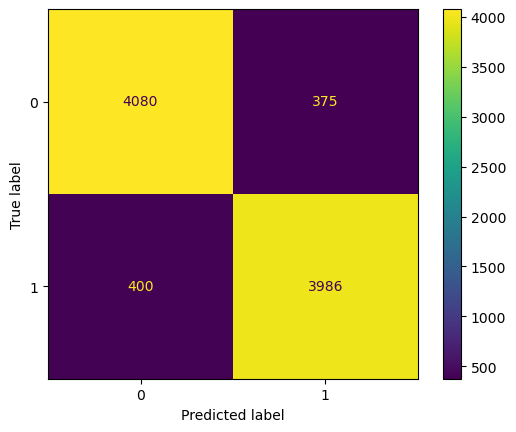

In [80]:
disp = ConfusionMatrixDisplay(confusion_matrix=baseline_confusionMatrix)
disp.plot()
plt.show()

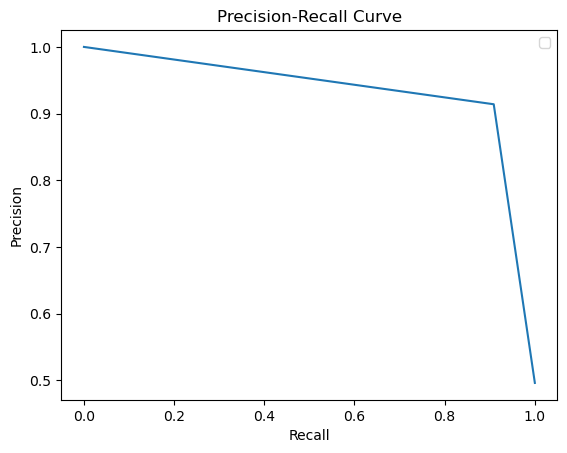

In [81]:
# plotting the baseline model
precision_curve, recall_curve, _ = precision_recall_curve(y_test_for_baseline, baseline_predictions)

plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# **Creating the model**

In [ ]:
def buildModel():
    model = Sequential()

    model.add(Embedding(len(tokenizer.index_word)+1, 64))
    model.add(Bidirectional(LSTM(64,  return_sequences=True)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(2, activation='sigmoid'))
    model.summary()
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [82]:
model = buildModel()

# Fit the model
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=epochs_num)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 64)          5008000   
                                                                 
 bidirectional_14 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_15 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 2)                 130       
                                                                 
Total params: 5,115,394
Trainable params: 5,115,394
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
592/592 [========================

In [83]:
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)

277/277 [==============================] - 8s 21ms/step


In [84]:
predictions = []
for i in range(len(y_pred)):
    if y_pred[i][0] > y_pred[i][1]:
        predictions.append(0)
    elif y_pred[i][0] <= y_pred[i][1]:
        predictions.append(1)
        
predictions = np.array(predictions)

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions);

print("Precision score = ", round(precision, 3))
print("Recall score = ", round(precision, 3))
print("Accuracy score = ", round(precision, 3))
print("F1 score = ", round(f1, 3))

Precision score =  0.919
Recall score =  0.919
Accuracy score =  0.919
F1 score =  0.917


In [85]:
confusionMatrix = confusion_matrix(y_test, predictions)
print("True negative : " , confusionMatrix[0][0])
print("False negative : " , confusionMatrix[0][1])
print("True positive : " , confusionMatrix[1][1])
print("False positive : " , confusionMatrix[1][0])

True negative :  4102
False negative :  353
True positive :  4016
False positive :  370


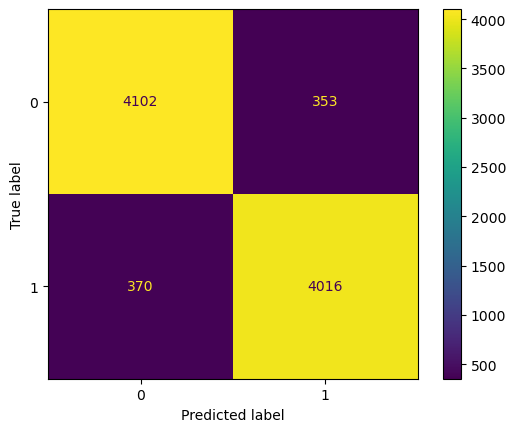

In [86]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix)
disp.plot()
plt.show()

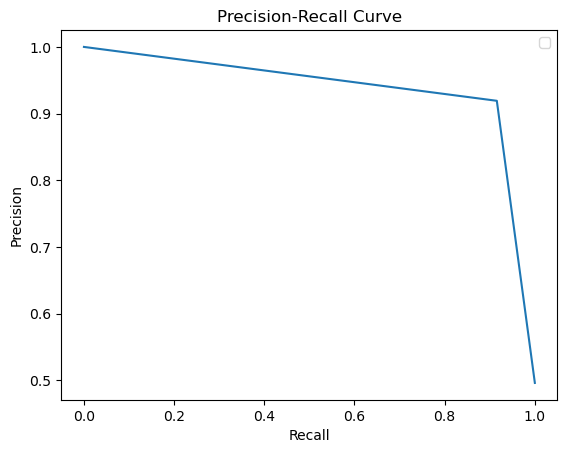

In [87]:
# plotting the bidirectional model
precision_curve, recall_curve, _ = precision_recall_curve(y_test, predictions)

plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

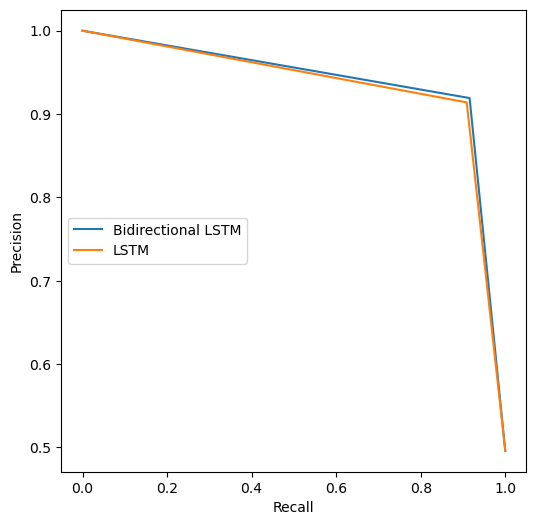

In [88]:
# plotting the baseline model with the bidirectional model
precision_curve, recall_curve, _ = precision_recall_curve(y_test, predictions)
baseline_precision_curve, baseline_recall_curve, _ = precision_recall_curve(y_test, baseline_predictions)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_curve, precision_curve, label='Bidirectional LSTM')
ax.plot(baseline_recall_curve, baseline_precision_curve, label='LSTM')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left')

# **Cross Validation**

In [90]:
model = buildModel()

epochs_num = 5
batch_size = 50
num_folds = 3 # number of folds
acc_per_fold = []
loss_per_fold = []

fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=True)
for train, test in kfold.split(X, y): 
    print(f'Fold No.{fold_no}')
    
    estimator = model.fit(X[train], y[train], 
                    batch_size=batch_size, epochs=epochs_num)
    
    scores = model.evaluate(X[test], y[test], verbose=0)
    
    print(f'Score for fold {fold_no}:')
    print(f'{model.metrics_names[0]} = {scores[0]}')
    print(f'{model.metrics_names[1]} = {round(scores[1], 3)*100}%')
    print("---------------------------")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 64)          5008000   
                                                                 
 bidirectional_18 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 2)                 130       
                                                                 
Total params: 5,115,394
Trainable params: 5,115,394
Non-trainable params: 0
_________________________________________________________________
Fold No.1
Epoch 1/5
512/512 [==============

In [91]:
for i in range(num_folds):
    print(f'Fold No.{i}')
    print(f'Accuracy = {acc_per_fold[i]}')
    print(f'Loss     = {loss_per_fold[i]}')
    print("-------------------------")
    
print('Average scores for all folds:')
print(f'Accuracy mean: {np.mean(acc_per_fold)}')
print(f'Accuracy std: {np.std(acc_per_fold)}')
print(f'Loss mean: {np.mean(loss_per_fold)}')
print(f'Loss std: {np.std(loss_per_fold)}')

Fold No.0
Accuracy = 88.53035569190979
Loss     = 0.3682863712310791
-------------------------
Fold No.1
Accuracy = 98.14033508300781
Loss     = 0.056599706411361694
-------------------------
Fold No.2
Accuracy = 99.15611743927002
Loss     = 0.02710867114365101
-------------------------
Average scores for all folds:
Accuracy mean: 95.27560273806255
Accuracy std: 4.787603557386354
Loss mean: 0.1506649162620306
Loss std: 0.15435187837627057


# **Input a tweet to analyze**

In [102]:
tweet_input = input("Write a tweet : ")

Write a tweet :  الطفل سعيد


In [103]:
tweet = clean_tweet(tweet_input)
tweet_test = ' '.join(tweet)
tweet_test = tokenizer.texts_to_sequences([tweet_test])
tweet_test = pad_sequences(tweet_test, 50)

tweet_test_prediction = model.predict(tweet_test)
if(tweet_test_prediction[0][0] > tweet_test_prediction[0][1]):
    print("negative")
elif(abs(tweet_test_prediction[0][0] - tweet_test_prediction[0][1]) < 0.2):
    print("neutral")
elif(tweet_test_prediction[0][0] <= tweet_test_prediction[0][1]):
    print("positive")
    
tweet_test_prediction

1/1 [==============================] - 0s 37ms/step
positive


array([[0.04429089, 0.9534945 ]], dtype=float32)